<a href="https://colab.research.google.com/github/stoianmihail/HyperTone/blob/main/HyperTone-init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import json
import os

DB_EPS = 1e-6
EPS = 1e-9

In [2]:
def get_files(path):
  ret = []
  for root, _, files in os.walk(path, topdown=False):
    for file in files:
      ret.append({'path': os.path.join(root,file), 'data' : None})
  return ret

In [3]:
hypertone_dir = '/content/drive/MyDrive/hypertone/'
preprocessing_data_file = hypertone_dir + 'preprocessing/data.json'
model_dir = hypertone_dir + 'model/'
model_file = hypertone_dir + 'model/model.h5'
directory = '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie'
tones = {tone : {'dir' : directory + '/utrenia-glas' + str(tone) + '-macarie/Inregistrari', 'files' : None} for tone in list(range(1, 8 + 1))}

In [4]:
tones

{1: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari',
  'files': None},
 2: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari',
  'files': None},
 3: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari',
  'files': None},
 4: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari',
  'files': None},
 5: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari',
  'files': None},
 6: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari',
  'files': None},
 7: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari',
  'files': None},
 8: {'

In [5]:
for tone in tones.keys():
  tones[tone]['files'] = get_files(tones[tone]['dir'])
tones[1]['files']

[{'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 9 Ceea ce eşti mai cinstită.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.2 Troparele.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 15 Preabinecuvântată eşti.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.6 Antifoanele.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.7 Prochimenul.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.12 Stihira 2 Laude.m4a'},
 {'data': 

In [6]:
kTones = 8
kBinsPerOctave = 24
# Corresponds to a jump from D -> F
kJump = int(4/3 * kBinsPerOctave)

fmin = librosa.midi_to_hz(36) # C2
fmax = librosa.midi_to_hz(84) # C6
print(fmin)
print(fmax)

65.40639132514966
1046.5022612023945


In [7]:
def debug_frequencies(freqs):
  print("size=" + str(len(freqs)))
  for index, elem in enumerate(freqs):
    c = '\n' if index % 8 == 0 else ' || '
    print(str(index) + " -> " + str(int(elem)),end=c)
  print('')
  pass


def debug(curr, b, e):
  for x in curr[b:e]:
    for elem in x:
      print(elem, end=',')
    print('')
  pass

def plot_lms(lms_, sr_):
  plt.figure(figsize=(30, 10))
  librosa.display.specshow(lms_, 
                          x_axis="time",
                          y_axis="mel", 
                          sr=sr_)
  plt.colorbar(format="%+2.f")
  plt.show()
  pass

def lower_bound(arr, needle):
# Lower-bound to find frequencies
  n = len(arr)
  lower, half = 0, n // 2
  while half:
    middle = lower + half;
    lower = middle if arr[middle] <= needle else lower
    n -= half
    half = n // 2
  return lower

In [8]:
# TODO: adaptively change this!
kOffset = 250 # 5 sec

# TODO: use also CQT_CHROMA!!!
def analyze_audio(filename, verbose=False):
  scale, sr = librosa.load(filename)
  fmin = librosa.midi_to_hz(36) # C2
  fmax = librosa.midi_to_hz(84) # C6 (not used)

  # TODO: put 24 bins per octave
  X = librosa.cqt(scale[kOffset:], sr=sr, fmin=fmin, bins_per_octave=kBinsPerOctave)  
  kBins = X.shape[0]
  print("initial=" + str(X.shape))

  print(librosa.cqt_frequencies(n_bins=kBins, fmin=fmin))
  pos_fmax = lower_bound(librosa.cqt_frequencies(n_bins=kBins, fmin=fmin), fmax)

  orig_logX = librosa.amplitude_to_db(abs(X))
  
  # Transpose
  logX = np.transpose(orig_logX).copy()

  # Zero-out minus db
  logX[logX < 0] = 0

  # Zero-out > fmax
  logX[:,(1 + pos_fmax):] = 0

  # Clear empty columns
  logX = logX[~np.all(logX < DB_EPS, axis=1)]

  # Scale
  # Do we need to rescale?
  #scaler = MinMaxScaler()
  #logX = scaler.fit_transform(logX)
  
  print("transofrmed=" + str(logX.shape))
  
  if verbose:
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(logX.T, sr=sr, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

  melody = []
  for index in range(len(logX)):
    tmp = np.zeros(kBinsPerOctave)
    for bin in range(kBins):
      tmp[bin % kBinsPerOctave] += logX[index][bin]
    max_pos = np.argmax(tmp)
    assert 0 <= max_pos and max_pos < kBinsPerOctave
    melody.append(max_pos)
  return np.asarray(melody)

In [9]:
def compress(a):
  return a[np.logical_or(np.insert(np.diff(a).astype(bool), 0, True), np.asarray(a, dtype=bool))]

# TODO: for half of second, get mean of the bin, since there might be noise!
def encode_audio(filename):
  melody = analyze_audio(filename)
  print(melody.shape)
  compressed = compress(np.diff(melody))
  print(compressed.shape)
  return melody, compressed

In [10]:
filename=tones[5]['files'][0]['path']
print(filename)
ipd.Audio(filename)

/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/Alte cantari glas 5/5 Voscreasna 5, glas 5.m4a


In [12]:
melody, encoded_audio = encode_audio(filename)
print(np.asarray([2**(i / kBinsPerOctave) * fmin for i in range(kBins)]))
plt.figure(figsize=(30, 10))
plt.plot(melody)
plt.xlim(xmin=0)
plt.show()

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 13232)
[  65.40639133   69.29565774   73.41619198   77.78174593   82.40688923
   87.30705786   92.49860568   97.998859    103.82617439  110.
  116.54094038  123.47082531  130.81278265  138.59131549  146.83238396
  155.56349186  164.81377846  174.61411572  184.99721136  195.99771799
  207.65234879  220.          233.08188076  246.94165063  261.6255653
  277.18263098  293.66476792  311.12698372  329.62755691  349.22823143
  369.99442271  391.99543598  415.30469758  440.          466.16376152
  493.88330126  523.2511306   554.36526195  587.32953583  622.25396744
  659.25511383  698.45646287  739.98884542  783.99087196  830.60939516
  880.          932.32752304  987.76660251 1046.5022612  1108.73052391
 1174.65907167 1244.50793489 1318.51022765 1396.91292573 1479.97769085
 1567.98174393 1661.21879032 1760.         1864.65504607 1975.53320502
 2093.0045224  2217.46104781 2349.31814334 2489.01586978 2637.0204553
 2793.82585146 2959.95538169 3135.96348785 3322.43758064 3520.
 372

NameError: ignored

In [15]:
#def test_lb():
#  arr = [2, 6, 10, 11, 18, 23]
#  def lookup(x):
#    print(lower_bound(arr, x))
#  lookup(1)
#  lookup(2)
#  lookup(5)
#  lookup(6)
#  lookup(19)
#  lookup(23)
#  lookup(24)

#import math

#def find_bin(fs, f):
# Find which bin `f` fits into.
# The bins are geometrically distributed
# by: 2**(i/`kBinsPerOctave`) * fmin
#  if math.isnan(f):
#    return f
#  lb = lower_bound(fs, f)
#  if lb == 0:
#    return int(f >= (fs[0] * fs[1])**0.5)
#  if lb == len(fs) - 1:
#    return lb
#  return lb + int(f >= (fs[lb] * fs[lb + 1])**0.5)

def find_bin(f):
# Find which bin `f` fits into.
# The bins are geometrically distributed.
# Formula: 2**(i/`kBinsPerOctave`) * fmin
# Source: https://en.wikipedia.org/wiki/Constant-Q_transform
  import math
  return int(round(math.log2(f / fmin) * kBinsPerOctave)) if not math.isnan(f) else f

#import random
#pyin_freqs = librosa.cqt_frequencies(n_bins=kBins, fmin=fmin)
#test = [random.uniform(fmin, fmax) for i in range(10000)]
#test_correct = np.asarray([find_bin(pyin_freqs, f) for f in test])
#test_estimated = np.asarray([find_bin_fast(f) for f in test])
#assert (test_correct == test_estimated).all()
#for index, (e1, e2) in enumerate(zip(test_correct, test_estimated)):
#  if e1 != e2:
#    print("bai=" + str(test[index]))
#    print(str(e1) + " vs " + str(e2))
#  pass

In [16]:
y, sr = librosa.load(filename)
f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=fmin, fmax=fmax)
times = librosa.times_like(f0)
pyin_bins = list(map(find_bin, f0))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
import matplotlib.pyplot as plt
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots(figsize=(30, 10))
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

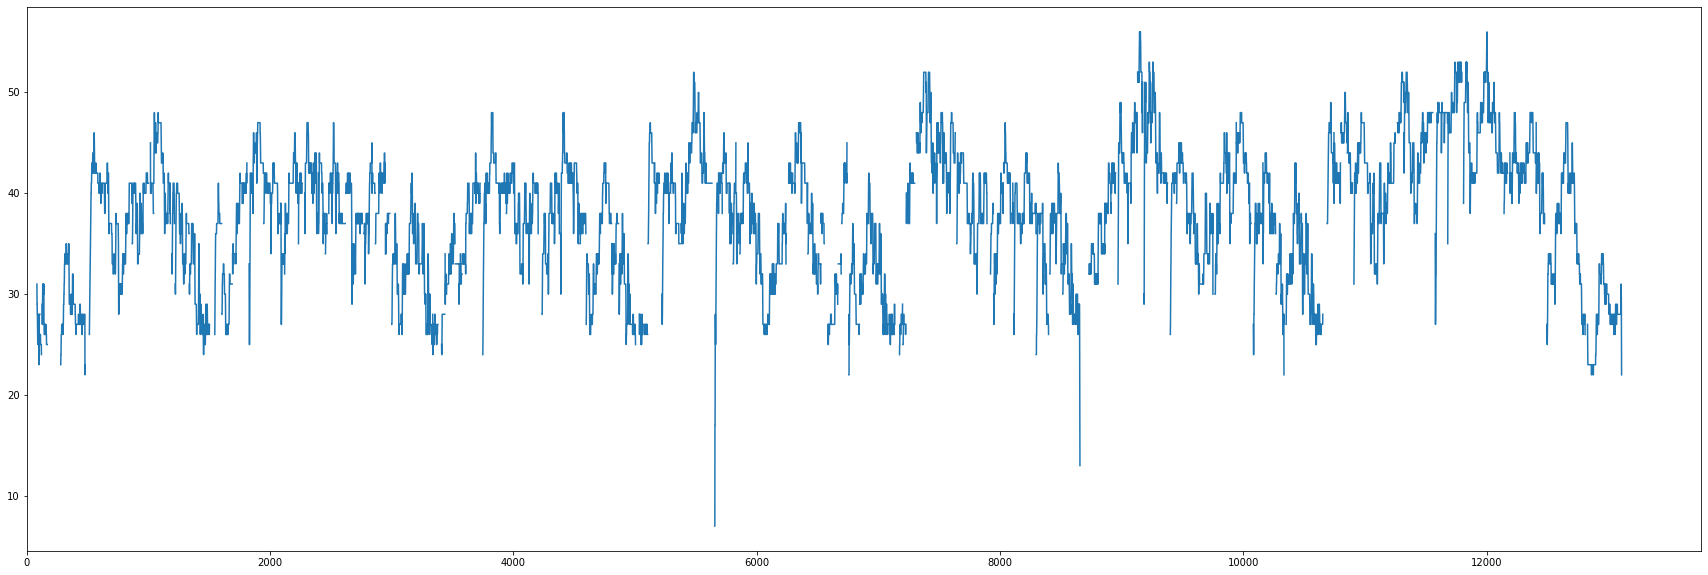

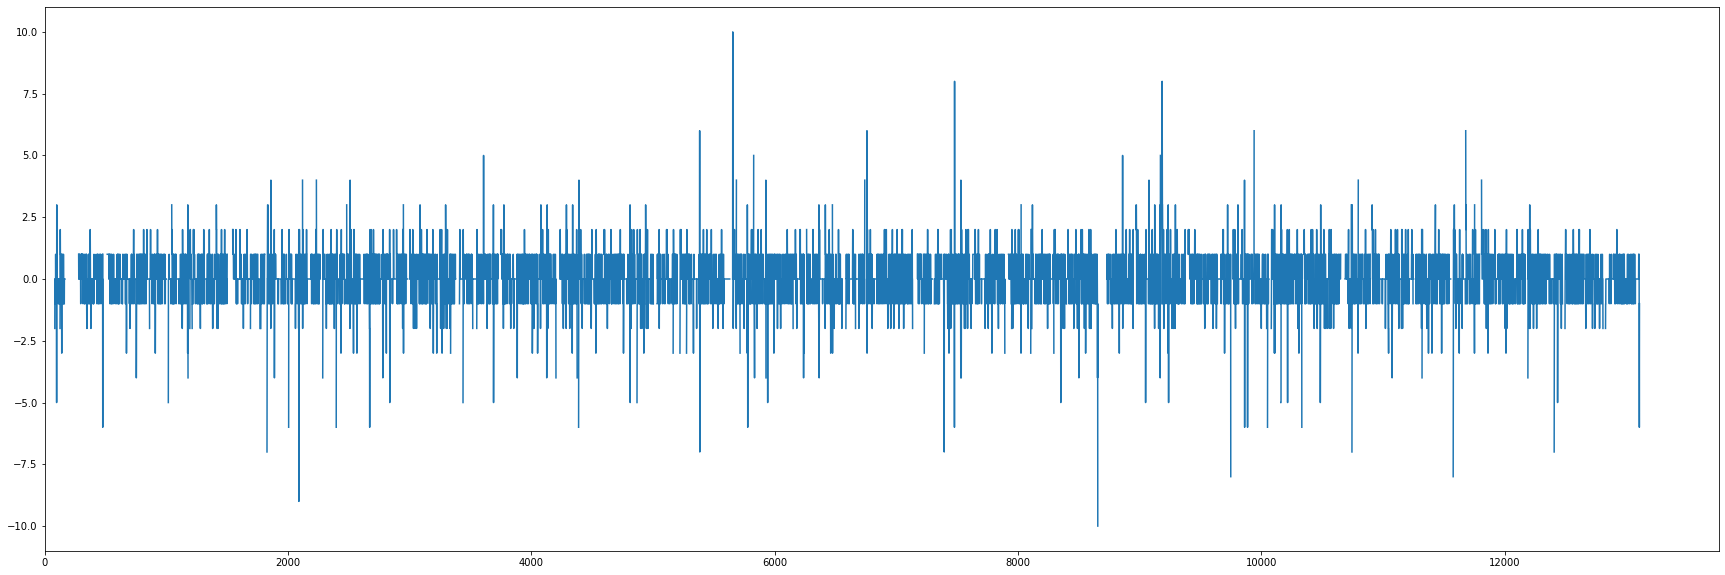

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(pyin_bins)
plt.xlim(xmin=0)
plt.show()

pitch_diff = []
last_index_non_nan = None
for index, elem in enumerate(pyin_bins):
  # First position?
  if index == 0:
    continue
  # NaN?
  if math.isnan(elem):
    continue
  # No prev elem which is not NaN?
  if last_index_non_nan is None:
    last_index_non_nan = index
    continue
  diff = elem - pyin_bins[last_index_no_nan]
  
  # Do we jump more than necessary?
  if abs(diff) > kJump:
    

  # Update
  last_index_non_nan = index

plt.figure(figsize=(30, 10))
plt.plot(np.diff(pyin_bins))
plt.xlim(xmin=0)
plt.show()



In [ ]:
def preprocess():
  for tone in tones:
    #if tone != 8 and tone != 1:
    #  continue
    print('Tone: ' + str(tone))
    count = 2
    for index, file in enumerate(tones[tone]['files']):
      #if index == count:
      #  break
      print('Audio: ' + file['path'])
      tones[tone]['files'][index]['data'] = encode_audio(file['path'])
  pass

In [ ]:
preprocess()

Tone: 1
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 9 Ceea ce eşti mai cinstită.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1760)
transofrmed=(909, 84)
(909,)
(417,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.2 Troparele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5844)
transofrmed=(4604, 84)
(4604,)
(2043,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 15 Preabinecuvântată eşti.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2765)
transofrmed=(2015, 84)
(2015,)
(867,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.6 Antifoanele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 9308)
transofrmed=(7767, 84)
(7767,)
(3717,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.7 Prochimenul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2410)
transofrmed=(2032, 84)
(2032,)
(982,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.12 Stihira 2 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2468)
transofrmed=(1963, 84)
(1963,)
(999,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.14 Stihira 4 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5117)
transofrmed=(4165, 84)
(4165,)
(1942,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.1 Dumnezeu este D.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1087)
transofrmed=(726, 84)
(726,)
(334,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.4 Al doilea rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 7204)
transofrmed=(5909, 84)
(5909,)
(2745,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.11 Stihira 1 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2102)
transofrmed=(1680, 84)
(1680,)
(835,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.10 Toată suflarea.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 4955)
transofrmed=(4147, 84)
(4147,)
(2194,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.3 Primul rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 7406)
transofrmed=(6227, 84)
(6227,)
(3265,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.13 Stihira 3 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2956)
transofrmed=(2478, 84)
(2478,)
(1211,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.8 Toată suflare ante Ev.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1687)
transofrmed=(1147, 84)
(1147,)
(493,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.5 Ipacoiul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1414)
transofrmed=(1066, 84)
(1066,)
(452,)
Tone: 2
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari/2. 15 Preabinecuvântată eşti.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2949)
transofrmed=(2174, 84)
(2174,)
(1002,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari/2.2 Troparele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5080)
transofrmed=(4227, 84)
(4227,)
(2021,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari/2.9 Ceea ce eşti mai cinstită.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1834)
transofrmed=(1021, 84)
(1021,)
(471,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari/2.7 Prochimenul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2276)
transofrmed=(1856, 84)
(1856,)
(868,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari/2.3 Primul rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 6238)
transofrmed=(5005, 84)
(5005,)
(2336,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari/2.6 Antifoanele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 9893)
transofrmed=(8150, 84)
(8150,)
(4123,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari/2.5 Ipacoiul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1908)
transofrmed=(1535, 84)
(1535,)
(739,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari/2.13 Stihira 3 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 4190)
transofrmed=(3619, 84)
(3619,)
(1725,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari/2.12 Stihira 2 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 4852)
transofrmed=(4219, 84)
(4219,)
(2117,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari/2.11 Stihira 1 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 3381)
transofrmed=(2761, 84)
(2761,)
(1419,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari/2.1 Dumnezeu este D.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1183)
transofrmed=(848, 84)
(848,)
(455,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari/2.10 Toată suflarea.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 4340)
transofrmed=(3696, 84)
(3696,)
(1836,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari/2.8 Toată suflarea ante Ev.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1823)
transofrmed=(1276, 84)
(1276,)
(583,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari/2.14 Stihira 4 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5928)
transofrmed=(5175, 84)
(5175,)
(2522,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari/2.4 Al doilea rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5937)
transofrmed=(4889, 84)
(4889,)
(2337,)
Tone: 3
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari/3.13 Stihira 3 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2913)
transofrmed=(2405, 84)
(2405,)
(1147,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari/3.11 Stihira 1 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2701)
transofrmed=(1944, 84)
(1944,)
(899,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari/3.10 Toată suflarea.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5727)
transofrmed=(4939, 84)
(4939,)
(2274,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari/3.9 Ceea ce eşti mai cinstită.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1744)
transofrmed=(1212, 84)
(1212,)
(549,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari/3.14 Stihira 4 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2550)
transofrmed=(2058, 84)
(2058,)
(933,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari/3. 15 Preabinecuvântată eşti.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2924)
transofrmed=(2243, 84)
(2243,)
(1089,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari/3.7 Prochimenul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1799)
transofrmed=(1487, 84)
(1487,)
(681,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari/3.3 Primul rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 6955)
transofrmed=(5839, 84)
(5839,)
(2827,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari/3.4 Al doilea rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 8604)
transofrmed=(7216, 84)
(7216,)
(3431,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari/3.6 Antifoanele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 10263)
transofrmed=(8573, 84)
(8573,)
(4103,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari/3.5 Ipacoiul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2517)
transofrmed=(2030, 84)
(2030,)
(983,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari/3. 1 Dumnezeu este D.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1074)
transofrmed=(791, 84)
(791,)
(413,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari/3.8 Toată suflarea ante Ev.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1665)
transofrmed=(1331, 84)
(1331,)
(653,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari/3.12 Stihira 2 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2304)
transofrmed=(1792, 84)
(1792,)
(822,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari/3.2 Troparele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 4592)
transofrmed=(3780, 84)
(3780,)
(1758,)
Tone: 4
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari/4.9 Ceea ce eşti mai cinstită.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1756)
transofrmed=(1100, 84)
(1100,)
(531,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari/4.8 Toată suflarea ante Ev.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1747)
transofrmed=(1217, 84)
(1217,)
(514,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari/4.6 Antifoanele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 9603)
transofrmed=(7950, 84)
(7950,)
(3782,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari/4.11 Stihira 1 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1625)
transofrmed=(1128, 84)
(1128,)
(570,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari/4.1 Dumnezeu este D.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1013)
transofrmed=(694, 84)
(694,)
(360,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari/4.14 Stihira 4 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2899)
transofrmed=(2347, 84)
(2347,)
(1102,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari/4.12 Stihira 2 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2544)
transofrmed=(1972, 84)
(1972,)
(929,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari/4.7 Prochimenul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1949)
transofrmed=(1504, 84)
(1504,)
(768,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari/4.2 Troparele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 4556)
transofrmed=(3688, 84)
(3688,)
(1624,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari/4.5 Ipacoiul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1682)
transofrmed=(1284, 84)
(1284,)
(620,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari/4. 15 Preabinecuvântată eşti.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2894)
transofrmed=(2144, 84)
(2144,)
(1065,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari/4.10 Toată suflarea.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 4285)
transofrmed=(3695, 84)
(3695,)
(1679,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari/4.4 Al doilea rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 8946)
transofrmed=(7279, 84)
(7279,)
(3421,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari/4.3 Primul rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 9479)
transofrmed=(7955, 84)
(7955,)
(3951,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari/4.13 Stihira 3 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2590)
transofrmed=(2083, 84)
(2083,)
(1012,)
Tone: 5
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/Alte cantari glas 5/5 Voscreasna 5, glas 5.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 13232)
transofrmed=(10861, 84)
(10861,)
(4843,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/Alte cantari glas 5/Sfânt este D.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2116)
transofrmed=(1614, 84)
(1614,)
(784,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/Alte cantari glas 5/Binecuvântările Învierii.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 12142)
transofrmed=(10248, 84)
(10248,)
(5258,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/Alte cantari glas 5/Pentru rugăciunile.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 7929)
transofrmed=(6552, 84)
(6552,)
(3124,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/Alte cantari glas 5/Doxologia glas 5.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 13373)
transofrmed=(11198, 84)
(11198,)
(5751,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/Alte cantari glas 5/5 Luminândele Învierii.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 7347)
transofrmed=(6039, 84)
(6039,)
(2854,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/5. 7 Prochimenul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1575)
transofrmed=(1211, 84)
(1211,)
(619,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/5. 11 Stihira 1 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 6828)
transofrmed=(5649, 84)
(5649,)
(2490,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/5. 14 Stihira 4 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 6526)
transofrmed=(5399, 84)
(5399,)
(2532,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/5. 10 Toată suflarea - Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5449)
transofrmed=(4654, 84)
(4654,)
(2151,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/5. 6 Antifoanele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 9724)
transofrmed=(8119, 84)
(8119,)
(4116,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/5. 13 Stihira 3 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5621)
transofrmed=(4579, 84)
(4579,)
(2105,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/5. 1 Dumnezeu este D.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1269)
transofrmed=(853, 84)
(853,)
(444,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/5. 4 Al doilea rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 8243)
transofrmed=(6887, 84)
(6887,)
(3442,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/5. 15 Preabinecuvântată eşti.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 3098)
transofrmed=(2377, 84)
(2377,)
(1228,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/5. 9 Ceea ce eşti mai cinstită.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2003)
transofrmed=(1475, 84)
(1475,)
(755,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/5. 12 Stihira 2 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 6076)
transofrmed=(5041, 84)
(5041,)
(2297,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/5. 5 Ipacoi.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2147)
transofrmed=(1744, 84)
(1744,)
(838,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/5. 2 Troparele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 4986)
transofrmed=(3960, 84)
(3960,)
(2021,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/5. 8 Toată suflarea ante Ev.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2043)
transofrmed=(1434, 84)
(1434,)
(730,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari/5. 3 Primul rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 6412)
transofrmed=(5221, 84)
(5221,)
(2570,)
Tone: 6
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6. 1 Dumnezeu este D.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1027)
transofrmed=(720, 84)
(720,)
(355,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.9 Ceea ce eşti mai cinstită.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1760)
transofrmed=(1101, 84)
(1101,)
(515,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.8 Toată suflarea ante Ev.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1578)
transofrmed=(1179, 84)
(1179,)
(587,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6. 15 Preabinecuvântată eşti.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2802)
transofrmed=(1825, 84)
(1825,)
(932,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.2 Troparele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 4810)
transofrmed=(3480, 84)
(3480,)
(1557,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.3 Primul rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 6595)
transofrmed=(4419, 84)
(4419,)
(1977,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.4 Al doilea rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5501)
transofrmed=(3721, 84)
(3721,)
(1763,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.5 Ipacoi.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1833)
transofrmed=(1313, 84)
(1313,)
(579,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.6 Antifoanele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 9359)
transofrmed=(6100, 84)
(6100,)
(2777,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.7 Prochimenul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1577)
transofrmed=(1115, 84)
(1115,)
(536,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.10 Toată suflarea - Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5319)
transofrmed=(4294, 84)
(4294,)
(1822,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.11 Stihira 1 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 3776)
transofrmed=(3017, 84)
(3017,)
(1294,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.12 Stihira 2 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 3772)
transofrmed=(2901, 84)
(2901,)
(1365,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.13 Stihira 3 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 3507)
transofrmed=(2831, 84)
(2831,)
(1269,)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.14 Stihira 4 Laude.m4a
initial=(84, 6101)
transofrmed=(4908, 84)
(4908,)
(2081,)
Tone: 7
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari/7. 1 Dumnezeu este D.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1078)
transofrmed=(781, 84)
(781,)
(373,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari/7.9 Ceea ce eşti mai cinstită.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1905)
transofrmed=(1117, 84)
(1117,)
(480,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari/7.8 Toată suflarea ante Ev.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1611)
transofrmed=(1006, 84)
(1006,)
(488,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari/7. 15 Preabinecuvântată eşti.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2913)
transofrmed=(2094, 84)
(2094,)
(1028,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari/7. 2 Troparele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 4677)
transofrmed=(3552, 84)
(3552,)
(1550,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari/7.3 Primul rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5219)
transofrmed=(3944, 84)
(3944,)
(1772,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari/7.4 Al doilea rând de sed.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 6408)
transofrmed=(4712, 84)
(4712,)
(2156,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari/7.5 Ipacoi.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1358)
transofrmed=(931, 84)
(931,)
(421,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari/7.6 Antifoanele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 10665)
transofrmed=(8296, 84)
(8296,)
(4124,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari/7.7 Prochimrnul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1996)
transofrmed=(1476, 84)
(1476,)
(682,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari/7.10 Toată suflarea - Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 4696)
transofrmed=(3647, 84)
(3647,)
(1751,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari/7.11 Stihira 1 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2189)
transofrmed=(1453, 84)
(1453,)
(652,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari/7.12 Stihira 2 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1744)
transofrmed=(1222, 84)
(1222,)
(545,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari/7.13 Stihira 3 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2037)
transofrmed=(1423, 84)
(1423,)
(616,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari/7.14 Stihira 4 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 4385)
transofrmed=(3332, 84)
(3332,)
(1543,)
Tone: 8
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.3 Primul rând de sedelne.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 9505)
transofrmed=(7408, 84)
(7408,)
(3294,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.7 Prochimenul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1485)
transofrmed=(1131, 84)
(1131,)
(471,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.10 Toată suflarea.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5149)
transofrmed=(4219, 84)
(4219,)
(1843,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.2 Troparele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 5095)
transofrmed=(3718, 84)
(3718,)
(1495,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.8 Toată suflarea ante Ev.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1617)
transofrmed=(997, 84)
(997,)
(393,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.11 Stihira 1 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2521)
transofrmed=(1727, 84)
(1727,)
(750,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.4 Al doilea rând de sedelne.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 7397)
transofrmed=(5874, 84)
(5874,)
(2669,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.6 Antifoanele.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 12289)
transofrmed=(8901, 84)
(8901,)
(3738,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.5 Ipacoiul.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2174)
transofrmed=(1593, 84)
(1593,)
(740,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.13 Stihira 3 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2365)
transofrmed=(1801, 84)
(1801,)
(793,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.9 Ceea ce eşti mai cinstită.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1764)
transofrmed=(1103, 84)
(1103,)
(497,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.14 Stihira 4 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2135)
transofrmed=(1473, 84)
(1473,)
(623,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8. 1 Dumnezeu este D.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1215)
transofrmed=(973, 84)
(973,)
(466,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8.12 Stihira 2 Laude.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2170)
transofrmed=(1512, 84)
(1512,)
(659,)
Audio: /content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas8-macarie/Inregistrari/8. 15 Preabinecuvântată eşti.m4a


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 2865)
transofrmed=(1992, 84)
(1992,)
(911,)


In [ ]:
def prepare_data():
  print('Save tones..')
  acc = []
  for tone in tones:
    print('Tone: ' + str(tone))
    for index, file in enumerate(tones[tone]['files']):
      if tones[tone]['files'][index]['data'] is not None:
        acc.append({'x': tones[tone]['files'][index]['data'].tolist(), 'y': tone - 1})
  return acc

with open(preprocessing_data_file, 'w') as f:
  data = prepare_data()
  json.dump(data, f, indent=2)

Save tones..
Tone: 1
Tone: 2
Tone: 3
Tone: 4
Tone: 5
Tone: 6
Tone: 7
Tone: 8


In [ ]:
import tensorflow.keras as keras

# TODO: check the best one!
kSequenceLength = 128
kOutputUnits = 2 * kBinsPerOctave - 1
kNumUnits = [128, 64]
kLoss = "categorical_crossentropy"
kLearningRate = 0.001
kEpochs = 5
kBatchSize = 64

In [ ]:
def load(path):
  with open(path, 'r') as f:
    return json.load(f)

In [ ]:
def generate_training_sequences(seq_len):
  """Create input and output data samples for training. Each sample is a sequence.

  :param sequence_length (int): Length of each sequence. With a quantisation at 16th notes, 64 notes equates to 4 bars

  :return inputs (ndarray): Training inputs
  :return targets (ndarray): Training targets
  """

  # load songs and map them to int
  songs = load(preprocessing_data_file)

  inputs, targets = [], []
  for elem in songs:
    x = np.asarray(elem['x'])
    y = elem['y']
    #x[np.insert(np.diff(x).astype(np.bool), 0, True)]
    if len(x) < seq_len:
      x.resize(seq_len)
    num_sequences = len(x) - seq_len + 1
    for index in range(num_sequences):
      inputs.append(x[index : index + seq_len])
      targets.append(y)

  # one-hot encode the sequences  
  # inputs size: (# of sequences, sequence length, vocabulary size)
  inputs = keras.utils.to_categorical(inputs, num_classes=kOutputUnits)
  print(inputs.shape)
  #n = len(inputs)
  #inputs = np.reshape(inputs, (n, seq_len, 1))
  # normalize input
  #inputs = inputs / float(kOutputUnits)
  
  targets = keras.utils.to_categorical(targets, num_classes=kTones)
  print(targets.shape)
  print(f"There are {len(inputs)} sequences.")
  return inputs, targets

In [ ]:
print(generate_training_sequences(kSequenceLength))

(183422, 128, 47)
(183422, 8)
There are 183422 sequences.
(array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0.,

In [ ]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.callbacks import ModelCheckpoint

def build_model(shape, output_units, num_units, loss, learning_rate):
    """Builds and compiles model

    :param output_units (int): Num output units
    :param num_units (list of int): Num of units in hidden layers
    :param loss (str): Type of loss function to use
    :param learning_rate (float): Learning rate to apply

    :return model (tf model): The model
    """

    # create the model architecture
    #input = keras.layers.Input(shape=(None, output_units))
    #x = keras.layers.LSTM(num_units[0])(input)
    #x = keras.layers.LSTM(num_units[1])(x)
    #x = keras.layers.Dropout(0.2)(x)
    #output = keras.layers.Dense(kTones, activation="softmax")(x)
    #model = keras.Model(input, output)

    # compile model
    #model.compile(loss=loss,
    #              optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    #              metrics=["accuracy"])

    print(shape)

    model = Sequential()
    model.add(LSTM(
        num_units[0],
        input_shape=(shape[1], shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
    model.add(LSTM(num_units[1]))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(kTones))
    model.add(Activation('softmax'))
    model.compile(loss=kLoss, optimizer='adam', metrics=["accuracy"])

    model.summary()
    return model

def train(output_units=kOutputUnits, num_units=kNumUnits, loss=kLoss, learning_rate=kLearningRate):
    """Train and save TF model.

    :param output_units (int): Num output units
    :param num_units (list of int): Num of units in hidden layers
    :param loss (str): Type of loss function to use
    :param learning_rate (float): Learning rate to apply
    """

    # generate the training sequences
    inputs, targets = generate_training_sequences(kSequenceLength)

    # build the network
    model = build_model(inputs.shape, output_units, num_units, loss, learning_rate)

    filepath = model_dir + "all-weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    # train the model
    model.fit(inputs, targets, epochs=kEpochs, batch_size=kBatchSize, callbacks=callbacks_list)

    # save the model
    model.save(model_file)

In [ ]:
train()

(183422, 128, 47)
(183422, 8)
There are 183422 sequences.
(183422, 128, 47)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 128)          90112     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
activation (Activation)      (None, 8)                 0         
Total params: 140,296
Trainable params: 140,16

In [ ]:
class HyperTone:
  """A class that wraps the LSTM model and offers utilities to generate melodies."""

  def __init__(self, path=model_file):
    """Constructor that initialises TensorFlow model"""
    self.model = keras.models.load_model(path)
  
  def extract_tones(self, x):
    # Pad, if necessary
    if len(x) < kSequenceLength:
      x.resize(kSequenceLength)

    y = []
    num_sequences = len(x) - kSequenceLength + 1
    print("num_sequences=" + str(num_sequences))
    for index in range(num_sequences):
      seed = x[index : index + kSequenceLength]

      #print(seed)

      # one-hot encode the seed
      onehot_seed = keras.utils.to_categorical(seed, num_classes=kOutputUnits)

      # (1, max_sequence_length, num of symbols in the vocabulary)
      onehot_seed = onehot_seed[np.newaxis, ...]


      #print(onehot_seed)

      # make a prediction
      probabilities = self.model.predict(onehot_seed)[0]
      #print(probabilities)
      index = self.sample(probabilities)
      y.append(1 + index)              
    return y

  def sample(self, probabilites, temperature=0.1):
    """Samples an index from a probability array reapplying softmax using temperature

    :param predictions (nd.array): Array containing probabilities for each of the possible outputs.
    :param temperature (float): Float in interval [0, 1]. Numbers closer to 0 make the model more deterministic.
        A number closer to 1 makes the generation more unpredictable.

    :return index (int): Selected output symbol
    """
    predictions = np.log(probabilites) / temperature
    probabilites = np.exp(predictions) / np.sum(np.exp(predictions))

    choices = range(len(probabilites)) # [0, 1, 2, 3]
    index = np.random.choice(choices, p=probabilites)

    return index

In [ ]:
f10 = tones[1]['files'][0]['path']
f11 = tones[1]['files'][2]['path']
f80 = tones[8]['files'][1]['path']
f81 = tones[8]['files'][4]['path']

In [ ]:
ipd.Audio(f11)

In [ ]:
ipd.Audio(f81)

In [ ]:
ht = HyperTone('/content/drive/MyDrive/hypertone/model/all-weights-improvement-05-0.0617-bigger.hdf5')
print(ht.extract_tones(encode_audio(f10)))
print(ht.extract_tones(encode_audio(f11)))
print(ht.extract_tones(encode_audio(f81)))
print(ht.extract_tones(encode_audio(f81)))

In [ ]:
test_filename = '/content/drive/MyDrive/hypertone/Utrenia_glas_1_Anastasimatar_Victor_Ojog/Anastasimatar Victor Ojog - Glasul I -  073 Dumnezeu este Domnul paralaghie.mp3'
ht = HyperTone('/content/drive/MyDrive/hypertone/model/all-weights-improvement-05-0.0617-bigger.hdf5')
print(ht.extract_tones(encode_audio(test_filename)))